<a href="https://colab.research.google.com/github/hilaler/text-classification-on-IMDB-review/blob/main/Experiment_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hilal Ramadhan Utomo (1301194236) dan Hajarot Najiha (1301194259)**

In [ ]:
import pandas as pd
import numpy as np
from time import time
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer , PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
import plotly.express as px
from sklearn import svm , model_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Eksplorasi Data

In [ ]:
df = pd.read_csv("https://github.com/hilaler/text-classification-on-IMDB-review/blob/main/IMDB%20Dataset.csv?raw=true")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Problem Statement

This is a dataset for binary sentiment classification
IMDB dataset having 10K movie reviews for natural language processing or Text analytics. dataset information:

Review = review dari para user terhadap sebuah film

Sentiment = opini dari pengguna berdasarkan review(Positive and Negative)

In [ ]:
#melihat distribusi label
fig = px.bar(df.groupby('sentiment').size().reset_index(name='count'), 
             x='sentiment', y='count', width=480, height=480, 
             barmode='group', title='Distribusi label')
fig.show(renderer='colab')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
# cek duplicated data
duplicates = df[df.duplicated()]
duplicates

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
6672,Sigh. I'm baffled when I see a short like this...,negative
7221,"I have always been a huge fan of ""Homicide: Li...",positive
7222,There are plenty of comments already posted sa...,negative
7425,"The movie was excellent, save for some of the ...",positive
7555,This movie has made me upset! When I think of ...,negative


In [ ]:
#drop dupliacate
df = df.drop_duplicates()

In [ ]:
# cek duplicated data
duplicates = df[df.duplicated()]
duplicates

,review,sentiment


In [ ]:
fig = px.bar(df.groupby('sentiment').size().reset_index(name='count'), 
             x='sentiment', y='count', width=480, height=480, 
             barmode='group', title='Distribusi label')
fig.show(renderer='colab')

In [ ]:
#mengecek data null
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df['sentiment'] = df['sentiment'].replace(['negative','positive'],['0','1'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Preprocessing

## Case Folding

In [ ]:
df['review'] = df['review'].str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


## Tokenizing & Removing Unwanted Char

In [ ]:
def remove_unwanted_char(text):
    # menghilangkan format html
    html_tag = re.compile(r'<.*?>')
    # menghilangkan format URL
    http_link = re.compile(r'https://\S+')
    www_link = re.compile(r'www\.\S+')
    # menghilangkan tanda baca
    punct = re.compile(r"[^\w\s]")
    # menghilangkan angka
    number = re.compile(r"\d")
    # menghilangkan double spasi
    space = re.compile(r"\s\s+")

    text = re.sub(html_tag, r" ", text)
    text = re.sub(http_link, r" ", text)
    text = re.sub(www_link, r" ", text)
    text = re.sub(punct, r" ", text)
    text = re.sub(number, r" ", text)
    text = re.sub(space, r" ", text)
    return text
                
df['review'] = df['review'].apply(remove_unwanted_char)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['review'] = df['review'].apply(remove_number)


#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['review'] = df['review'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)


# NLTK word rokenize 
df['token'] = df['review'].apply(lambda x: word_tokenize(x))


df.head()

,review,sentiment,token
0,one of the other reviewers has mentioned that ...,1,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production the filming tech...,1,"[a, wonderful, little, production, the, filmin..."
2,i thought this was a wonderful way to spend ti...,1,"[i, thought, this, was, a, wonderful, way, to,..."
3,basically there s a family where a little boy ...,0,"[basically, there, s, a, family, where, a, lit..."
4,petter mattei s love in the time of money is a...,1,"[petter, mattei, s, love, in, the, time, of, m..."


## Stopword Removal

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
df['no_stopwords'] = df['token'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,review,sentiment,token,no_stopwords
0,one of the other reviewers has mentioned that ...,1,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis..."
1,a wonderful little production the filming tech...,1,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,1,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su..."
3,basically there s a family where a little boy ...,0,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,..."
4,petter mattei s love in the time of money is a...,1,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ..."


## Stemming

In [ ]:
# create stemmer
stemmer = PorterStemmer()
df['stemming'] = df['no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
df.head()

,review,sentiment,token,no_stopwords,stemming
0,one of the other reviewers has mentioned that ...,1,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis...","[one, review, mention, watch, oz, episod, hook..."
1,a wonderful little production the filming tech...,1,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass..."
2,i thought this was a wonderful way to spend ti...,1,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,basically there s a family where a little boy ...,0,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,...","[basic, famili, littl, boy, jake, think, zombi..."
4,petter mattei s love in the time of money is a...,1,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visual, st..."


## Lemmanization

In [ ]:
lemmatizer = WordNetLemmatizer()
df['lemmatize'] = df['stemming'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df.head()

,review,sentiment,token,no_stopwords,stemming,lemmatize
0,one of the other reviewers has mentioned that ...,1,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis...","[one, review, mention, watch, oz, episod, hook...","[one, review, mention, watch, oz, episod, hook..."
1,a wonderful little production the filming tech...,1,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonder, littl, product, film, techniqu, unass..."
2,i thought this was a wonderful way to spend ti...,1,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe..."
3,basically there s a family where a little boy ...,0,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,...","[basic, famili, littl, boy, jake, think, zombi...","[basic, famili, littl, boy, jake, think, zombi..."
4,petter mattei s love in the time of money is a...,1,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st..."


## Final Clean data

In [ ]:
df["clean_title"] = df["lemmatize"].apply(lambda x: " ".join(x))
df.head()

,review,sentiment,token,no_stopwords,stemming,lemmatize,clean_title
0,one of the other reviewers has mentioned that ...,1,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis...","[one, review, mention, watch, oz, episod, hook...","[one, review, mention, watch, oz, episod, hook...",one review mention watch oz episod hook right ...
1,a wonderful little production the filming tech...,1,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...","[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...
2,i thought this was a wonderful way to spend ti...,1,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...","[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...
3,basically there s a family where a little boy ...,0,"[basically, there, s, a, family, where, a, lit...","[basically, family, little, boy, jake, thinks,...","[basic, famili, littl, boy, jake, think, zombi...","[basic, famili, littl, boy, jake, think, zombi...",basic famili littl boy jake think zombi closet...
4,petter mattei s love in the time of money is a...,1,"[petter, mattei, s, love, in, the, time, of, m...","[petter, mattei, love, time, money, visually, ...","[petter, mattei, love, time, money, visual, st...","[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...


# Feature Extraction

## TF-IDF

In [ ]:
# tf-idf 
tfidf = TfidfVectorizer()
text_tfidf = tfidf.fit_transform(df['clean_title'].values.tolist())
text_tfidf.shape

(9983, 34982)

## Spilt data

In [ ]:
# membagi train test data (tfidf)
X = text_tfidf
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train : ", (X_train.shape))
print("y Train : ", (y_train.shape))
print("X Test : ", (X_test.shape))
print("y Test : ", (y_test.shape))

X Train :  (7986, 34982)
y Train :  (7986,)
X Test :  (1997, 34982)
y Test :  (1997,)


# Klasifikasi

## Naive Bayes (Multinomial)

In [ ]:
# modelling dengan Multinomial Naive Bayes
start = time()
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print('******** Multinomial Naive Bayes Classifier **********')
print('MultinomialNB Accuracy:', accuracy_score(y_test, predicted))
print('MultinomialNB Precision:', precision_score(y_test, predicted, average=None))
print('MultinomialNB Recall:', recall_score(y_test, predicted, average=None))
print('MultinomialNB f1_score:', f1_score(y_test, predicted, average=None))
print('Waktu untuk membangun model : {} detik'.format(round((time() - start))))

******** Multinomial Naive Bayes Classifier **********
MultinomialNB Accuracy: 0.8652979469203805
MultinomialNB Precision: [0.84960938 0.88180884]
MultinomialNB Recall: [0.88324873 0.84782609]
MultinomialNB f1_score: [0.86610254 0.86448363]
Waktu untuk membangun model : 0 detik


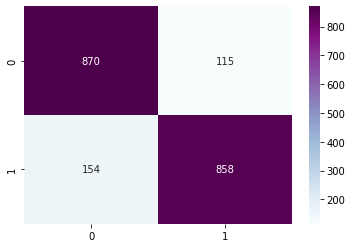

In [ ]:
# confusion matrix of Naive Bayes
cmrfc = confusion_matrix(y_test,predicted)
sns.heatmap(cmrfc,cmap='BuPu',annot=True,fmt='d')

In [ ]:
#clasification report Naive Bayes
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       985
           1       0.88      0.85      0.86      1012

    accuracy                           0.87      1997
   macro avg       0.87      0.87      0.87      1997
weighted avg       0.87      0.87      0.87      1997



## Random Forest

In [ ]:
# Modelling dengan Random Forest
start = time()
rfc = RandomForestClassifier(random_state=0).fit(X_train,y_train)
predicted_rfc=rfc.predict(X_test)
print('******** Random Forest Classifier **********')
print('Random Forest Accuracy:', accuracy_score(y_test, predicted_rfc))
print('Random Forest Precision:', precision_score(y_test, predicted_rfc, average=None))
print('Random Forest Recall:', recall_score(y_test, predicted_rfc, average=None))
print('Random Forest f1_score:', f1_score(y_test, predicted_rfc, average=None))
print('Waktu untuk membangun model : {} menit'.format(round((time() - start) / 60, 2)))

******** Random Forest Classifier **********
Random Forest Accuracy: 0.85678517776665
Random Forest Precision: [0.86444213 0.84971098]
Random Forest Recall: [0.84162437 0.8715415 ]
Random Forest f1_score: [0.85288066 0.8604878 ]
Waktu untuk membangun model : 0.23 menit


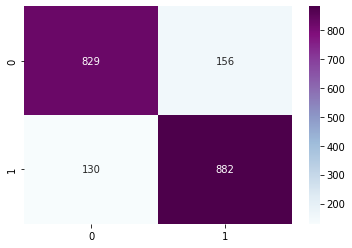

In [ ]:
# confusion matrix of Random Forest
cmrfc = confusion_matrix(y_test,predicted_rfc)
sns.heatmap(cmrfc,cmap='BuPu',annot=True,fmt='d')

In [ ]:
#clasification report Random Forest
print(classification_report(y_test, predicted_rfc))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       985
           1       0.85      0.87      0.86      1012

    accuracy                           0.86      1997
   macro avg       0.86      0.86      0.86      1997
weighted avg       0.86      0.86      0.86      1997



## SVM

In [ ]:
start = time()
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print('******** SVM **********')
print('SVM Accuracy:', accuracy_score(y_test, predictions_SVM))
print('SVM Precision:', precision_score(y_test, predictions_SVM, average=None))
print('SVM Recall:', recall_score(y_test, predictions_SVM, average=None))
print('SVM f1_score:', f1_score(y_test, predictions_SVM, average=None))
print('Waktu untuk membangun model : {} menit'.format(round((time() - start) / 60, 2)))

******** SVM **********
SVM Accuracy: 0.8873309964947421
SVM Precision: [0.89832285 0.87727709]
SVM Recall: [0.87005076 0.9041502 ]
SVM f1_score: [0.8839608  0.89051095]
Waktu untuk membangun model : 0.82 menit


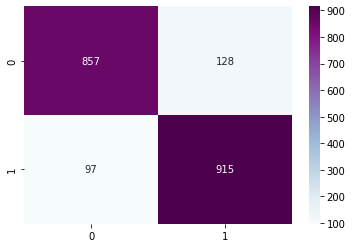

In [ ]:
# confusion matrix of SVM
cmrfc = confusion_matrix(y_test,predictions_SVM)
sns.heatmap(cmrfc,cmap='BuPu',annot=True,fmt='d')

In [ ]:
#clasification report Random Forest
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       985
           1       0.88      0.90      0.89      1012

    accuracy                           0.89      1997
   macro avg       0.89      0.89      0.89      1997
weighted avg       0.89      0.89      0.89      1997



# Kesimpulan

In [ ]:
print('******** CONCLUSION **********')
print('MultinomialNB Accuracy:', accuracy_score(y_test, predicted))
print('Random Forest Accuracy:', accuracy_score(y_test, predicted_rfc))
print('SVM Accuracy:', accuracy_score(y_test, predictions_SVM))

******** CONCLUSION **********
MultinomialNB Accuracy: 0.8652979469203805
Random Forest Accuracy: 0.85678517776665
SVM Accuracy: 0.8873309964947421
